## Details

The notebook contains the synthetic data experiment with low noise (sigma^2 = 0.05). Due to the non-convexity of the HNCPD task, results will vary run to run, so the results from this notebook will not exactly match those in the paper.

In [1]:
# loading packages and functions
import sys

sys.path.append("./src")
import torch
import numpy as np
from matplotlib import pyplot as plt

from NNCPD import NNCPD, weights_H, Energy_Loss_Tensor, Recon_Loss, Recon_Loss_Straight, Recon_Loss_NMF, L21_Norm, outer_product, outer_product_np, PTF, random_NNCPD, Fro_Norm
from lsqnonneg_module import LsqNonneg
from trainNNCPD import train_unsupervised, train_supervised
#
import torch.nn as nn
from torch.autograd import Variable
from writer import Writer

from sklearn.decomposition import NMF

import tensorly as tl
from tensorly import unfold as tl_unfold
from tensorly.decomposition import parafac, non_negative_parafac

Using numpy backend.


## Generate Data Tensor

In [2]:
## set the network parameters
torch.set_default_tensor_type(torch.DoubleTensor)


n1 = 40
n2 = 40
n3 = 40

r = 12


a = 1
b = 3

X = np.zeros((40,40,40))


X[0:10,0:15,0:15] = a * np.ones((10,15,15))
X[10:25,15:25,15:30] = a * np.ones((15,10,15))
X[25:40,25:40,30:40] = a * np.ones((15,15,10))

X[0:5,0:10,0:5] = b
X[5:10,10:15,5:15] = b

X[10:15,15:18,15:20] = b
X[15:20,18:23,20:25] = b
X[20:25,23:25,25:30] = b

X[25:30,25:35,30:35] = b
X[30:40,35:40,35:40] = b

#add Gaussian Noise
np.random.seed(0)
X = X + 0.05 * np.abs(np.random.randn(40, 40, 40))

In [3]:
#set a consistent vmin and vmax for visualization
vmin=0
vmax=3

### Visualize Original Data Tensor

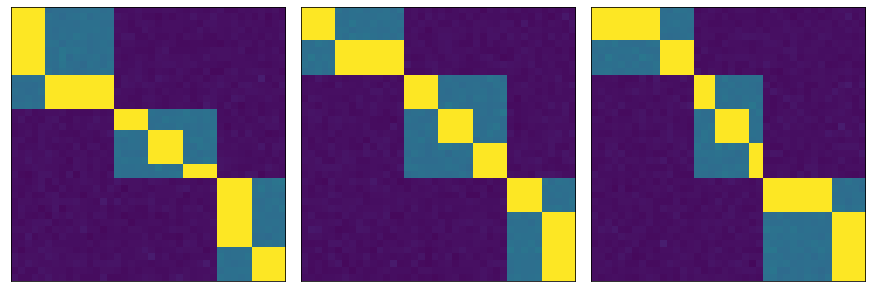

In [4]:
fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(12,5))
axs[0].axes.get_xaxis().set_ticks([])
axs[0].axes.get_yaxis().set_ticks([])
axs[1].axes.get_xaxis().set_ticks([])
axs[1].axes.get_yaxis().set_ticks([])
axs[2].axes.get_xaxis().set_ticks([])
axs[2].axes.get_yaxis().set_ticks([])
color = "viridis"
X_max = np.max(X,axis=0)
axs[0].imshow(X_max, cmap=plt.get_cmap(color), vmin=vmin, vmax=vmax)
X_max = np.max(X,axis=1)
axs[1].imshow(X_max, cmap=plt.get_cmap(color), vmin=vmin, vmax=vmax)
X_max = np.max(X,axis=2)
axs[2].imshow(X_max, cmap=plt.get_cmap(color), vmin=vmin, vmax=vmax)
plt.show()

In [5]:
X = torch.from_numpy(X)
X_np = np.asarray(X)

## Run Neural NCPD

In [6]:
# unsupervised case,one layer
r=7
n1,n2,n3 = X.shape
net = NNCPD([n1, 5, 3],[n2, 5, 3],[n3, 5, 3])

loss_func = Energy_Loss_Tensor()

history_unsupervised = train_unsupervised(net, X, loss_func, r, epoch = 10000, lr1 = 0, lr2 = 50, weight_decay=0.995)


/Users/jvendrow/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


finished tensorly
epoch =  1 
 tensor(0.5026)
epoch =  11 
 tensor(0.5064)
epoch =  21 
 tensor(0.4784)
epoch =  31 
 tensor(0.4387)
epoch =  41 
 tensor(0.3839)
epoch =  51 
 tensor(0.3295)
epoch =  61 
 tensor(0.2759)
epoch =  71 
 tensor(0.2445)
epoch =  81 
 tensor(0.2373)
epoch =  91 
 tensor(0.2356)
epoch =  101 
 tensor(0.2350)
epoch =  111 
 tensor(0.2348)
epoch =  121 
 tensor(0.2346)
epoch =  131 
 tensor(0.2344)
epoch =  141 
 tensor(0.2341)
epoch =  151 
 tensor(0.2328)
epoch =  161 
 tensor(0.2275)
epoch =  171 
 tensor(0.2100)
epoch =  181 
 tensor(0.1890)
epoch =  191 
 tensor(0.1761)
epoch =  201 
 tensor(0.1246)
epoch =  211 
 tensor(0.1214)
epoch =  221 
 tensor(0.1209)
epoch =  231 
 tensor(0.1208)
epoch =  241 
 tensor(0.1207)
epoch =  251 
 tensor(0.1207)
epoch =  261 
 tensor(0.1207)
epoch =  271 
 tensor(0.1207)
epoch =  281 
 tensor(0.1207)
epoch =  291 
 tensor(0.1207)
epoch =  301 
 tensor(0.1207)
epoch =  311 
 tensor(0.1207)
epoch =  321 
 tensor(0.1207)
epo

epoch =  2691 
 tensor(0.0978)
epoch =  2701 
 tensor(0.0978)
epoch =  2711 
 tensor(0.0978)
epoch =  2721 
 tensor(0.0978)
epoch =  2731 
 tensor(0.0978)
epoch =  2741 
 tensor(0.0978)
epoch =  2751 
 tensor(0.0978)
epoch =  2761 
 tensor(0.0978)
epoch =  2771 
 tensor(0.0978)
epoch =  2781 
 tensor(0.0978)
epoch =  2791 
 tensor(0.0978)
epoch =  2801 
 tensor(0.0978)
epoch =  2811 
 tensor(0.0978)
epoch =  2821 
 tensor(0.0978)
epoch =  2831 
 tensor(0.0978)
epoch =  2841 
 tensor(0.0978)
epoch =  2851 
 tensor(0.0978)
epoch =  2861 
 tensor(0.0978)
epoch =  2871 
 tensor(0.0978)
epoch =  2881 
 tensor(0.0978)
epoch =  2891 
 tensor(0.0978)
epoch =  2901 
 tensor(0.0978)
epoch =  2911 
 tensor(0.0978)
epoch =  2921 
 tensor(0.0978)
epoch =  2931 
 tensor(0.0978)
epoch =  2941 
 tensor(0.0978)
epoch =  2951 
 tensor(0.0978)
epoch =  2961 
 tensor(0.0978)
epoch =  2971 
 tensor(0.0978)
epoch =  2981 
 tensor(0.0978)
epoch =  2991 
 tensor(0.0978)
epoch =  3001 
 tensor(0.0978)
epoch = 

epoch =  5341 
 tensor(0.0978)
epoch =  5351 
 tensor(0.0978)
epoch =  5361 
 tensor(0.0977)
epoch =  5371 
 tensor(0.0977)
epoch =  5381 
 tensor(0.0977)
epoch =  5391 
 tensor(0.0978)
epoch =  5401 
 tensor(0.0977)
epoch =  5411 
 tensor(0.0977)
epoch =  5421 
 tensor(0.0977)
epoch =  5431 
 tensor(0.0977)
epoch =  5441 
 tensor(0.0979)
epoch =  5451 
 tensor(0.0977)
epoch =  5461 
 tensor(0.0977)
epoch =  5471 
 tensor(0.0977)
epoch =  5481 
 tensor(0.0977)
epoch =  5491 
 tensor(0.0977)
epoch =  5501 
 tensor(0.0977)
epoch =  5511 
 tensor(0.0977)
epoch =  5521 
 tensor(0.0977)
epoch =  5531 
 tensor(0.0977)
epoch =  5541 
 tensor(0.0977)
epoch =  5551 
 tensor(0.0976)
epoch =  5561 
 tensor(0.0976)
epoch =  5571 
 tensor(0.0976)
epoch =  5581 
 tensor(0.0976)
epoch =  5591 
 tensor(0.0976)
epoch =  5601 
 tensor(0.0977)
epoch =  5611 
 tensor(0.0977)
epoch =  5621 
 tensor(0.0976)
epoch =  5631 
 tensor(0.0977)
epoch =  5641 
 tensor(0.0977)
epoch =  5651 
 tensor(0.0979)
epoch = 

epoch =  7991 
 tensor(0.0976)
epoch =  8001 
 tensor(0.0976)
epoch =  8011 
 tensor(0.0976)
epoch =  8021 
 tensor(0.0976)
epoch =  8031 
 tensor(0.0976)
epoch =  8041 
 tensor(0.0976)
epoch =  8051 
 tensor(0.0976)
epoch =  8061 
 tensor(0.0976)
epoch =  8071 
 tensor(0.0976)
epoch =  8081 
 tensor(0.0976)
epoch =  8091 
 tensor(0.0976)
epoch =  8101 
 tensor(0.0979)
epoch =  8111 
 tensor(0.0977)
epoch =  8121 
 tensor(0.0976)
epoch =  8131 
 tensor(0.0976)
epoch =  8141 
 tensor(0.0976)
epoch =  8151 
 tensor(0.0976)
epoch =  8161 
 tensor(0.0976)
epoch =  8171 
 tensor(0.0976)
epoch =  8181 
 tensor(0.0976)
epoch =  8191 
 tensor(0.0977)
epoch =  8201 
 tensor(0.0976)
epoch =  8211 
 tensor(0.0976)
epoch =  8221 
 tensor(0.0976)
epoch =  8231 
 tensor(0.0976)
epoch =  8241 
 tensor(0.0976)
epoch =  8251 
 tensor(0.0976)
epoch =  8261 
 tensor(0.0976)
epoch =  8271 
 tensor(0.0976)
epoch =  8281 
 tensor(0.0976)
epoch =  8291 
 tensor(0.0976)
epoch =  8301 
 tensor(0.0976)
epoch = 

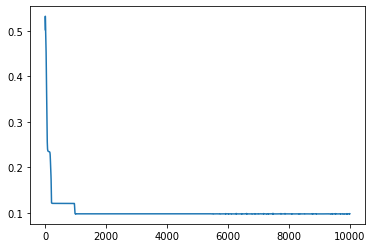

In [7]:
# plot the loss curve
history_unsupervised.plot_scalar('loss')

In [8]:
X1 = history_unsupervised.get('A_X1')[-1]
X2 = history_unsupervised.get('B_X1')[-1]
X3 = history_unsupervised.get('C_X1')[-1]


A_A1 = history_unsupervised.get('A_A1')[-1]
A_S1 = history_unsupervised.get('A_S1')[-1]
B_A1 = history_unsupervised.get('B_A1')[-1]
B_S1 = history_unsupervised.get('B_S1')[-1]
C_A1 = history_unsupervised.get('C_A1')[-1]
C_S1 = history_unsupervised.get('C_S1')[-1]

A_A2 = history_unsupervised.get('A_A2')[-1]
A_S2 = history_unsupervised.get('A_S2')[-1]
B_A2 = history_unsupervised.get('B_A2')[-1]
B_S2 = history_unsupervised.get('B_S2')[-1]
C_A2 = history_unsupervised.get('C_A2')[-1]
C_S2 = history_unsupervised.get('C_S2')[-1]


### Visualize S Matrices

Note that these S matrices will not look as nice as the S matrices in the paper. This is because the order of topics in NCPD is arbitrary, so to get a "nice" S matrix one needs to reorder the topics

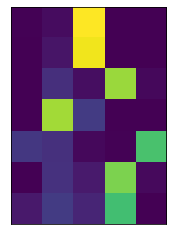

In [9]:
plt.xticks([], [])
plt.yticks([], [])
plt.imshow((C_S1 / torch.mean(C_S1, axis=0)).T)

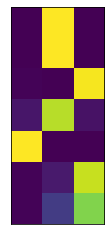

In [10]:
plt.xticks([], [])
plt.yticks([], [])
plt.imshow((C_S2 / torch.mean(C_S2, axis=0)).T)

### Rank 7 Approximation (for both Neural NCPD and Standard HNCPD)

Reconstruction loss: 40.15613447453781
Relative reconstruction loss: 0.3023244082890623


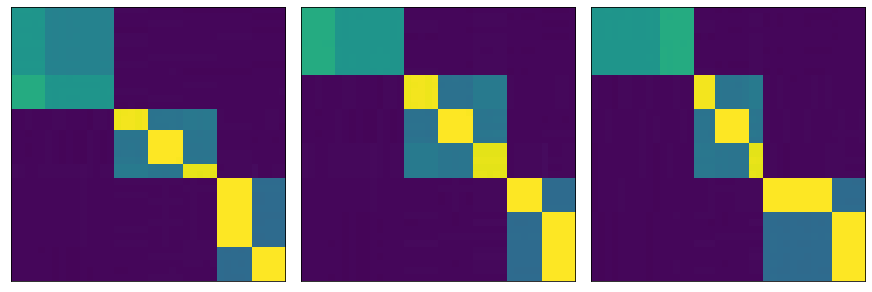

In [11]:
approx = outer_product(X1, X2, X3).numpy()
print("Reconstruction loss:", np.linalg.norm(np.ndarray.flatten(X_np-approx), 2))
print("Relative reconstruction loss:", np.linalg.norm(np.ndarray.flatten(X_np-approx), 2)  / np.linalg.norm(np.ndarray.flatten(X_np), 2))

fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(12,5))
axs[0].axes.get_xaxis().set_ticks([])
axs[0].axes.get_yaxis().set_ticks([])
axs[1].axes.get_xaxis().set_ticks([])
axs[1].axes.get_yaxis().set_ticks([])
axs[2].axes.get_xaxis().set_ticks([])
axs[2].axes.get_yaxis().set_ticks([])
X_max = np.max(approx,axis=0)
axs[0].imshow(X_max, vmin=vmin, vmax=vmax)
X_max = np.max(approx,axis=1)
axs[1].imshow(X_max, vmin=vmin, vmax=vmax)
X_max = np.max(approx,axis=2)
axs[2].imshow(X_max, vmin=vmin, vmax=vmax)
plt.show()

### Rank 5 Approximation for Neural NCPD

Reconstruction loss: 48.97543050025518
Relative reconstruction loss: 0.3687224440410275


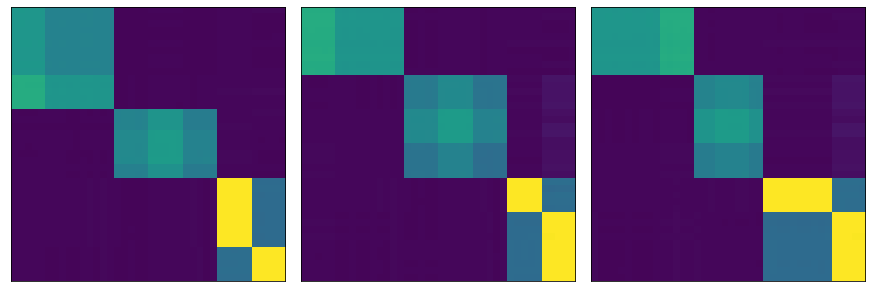

In [12]:
approx = outer_product(torch.mm(A_A1,A_S1), torch.mm(B_A1,B_S1), torch.mm(C_A1,C_S1)).numpy()

print("Reconstruction loss:", np.linalg.norm(np.ndarray.flatten(X_np-approx), 2))
print("Relative reconstruction loss:", np.linalg.norm(np.ndarray.flatten(X_np-approx), 2)  / np.linalg.norm(np.ndarray.flatten(X_np), 2))


fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(12,5))
axs[0].axes.get_xaxis().set_ticks([])
axs[0].axes.get_yaxis().set_ticks([])
axs[1].axes.get_xaxis().set_ticks([])
axs[1].axes.get_yaxis().set_ticks([])
axs[2].axes.get_xaxis().set_ticks([])
axs[2].axes.get_yaxis().set_ticks([])
X_max = np.max(approx,axis=0)
axs[0].imshow(X_max, vmin=vmin, vmax=vmax)
X_max = np.max(approx,axis=1)
axs[1].imshow(X_max, vmin=vmin, vmax=vmax)
X_max = np.max(approx,axis=2)
axs[2].imshow(X_max, vmin=vmin, vmax=vmax)

plt.show()

### Rank 3 Approximation for Neural NCPD

Reconstruction loss: 62.12829018040007
Relative reconstruction loss: 0.4677466796190372
1.9212999906874546


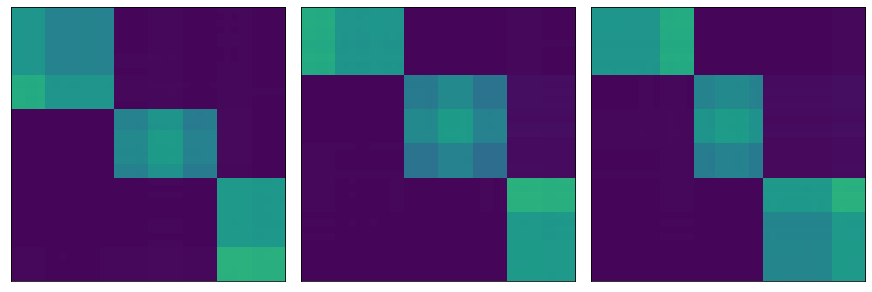

In [13]:
approx = outer_product(torch.mm(A_A1, torch.mm(A_A2,A_S2)), torch.mm(B_A1, torch.mm(B_A2,B_S2)), torch.mm(C_A1, torch.mm(C_A2,C_S2))).numpy()


print("Reconstruction loss:", np.linalg.norm(np.ndarray.flatten(X_np-approx), 2))
print("Relative reconstruction loss:", np.linalg.norm(np.ndarray.flatten(X_np-approx), 2)  / np.linalg.norm(np.ndarray.flatten(X_np), 2))

print(np.max(approx))
fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(12,5))
axs[0].axes.get_xaxis().set_ticks([])
axs[0].axes.get_yaxis().set_ticks([])
axs[1].axes.get_xaxis().set_ticks([])
axs[1].axes.get_yaxis().set_ticks([])
axs[2].axes.get_xaxis().set_ticks([])
axs[2].axes.get_yaxis().set_ticks([])
X_max = np.max(approx,axis=0)
axs[0].imshow(X_max, vmin=vmin, vmax=vmax)
X_max = np.max(approx,axis=1)
axs[1].imshow(X_max, vmin=vmin, vmax=vmax)
X_max = np.max(approx,axis=2)
axs[2].imshow(X_max, vmin=vmin, vmax=vmax)

plt.show()

## Standard HNCPD

In [14]:
#rank 7 (same as Neural NNCPD)
X_np = np.asarray(X)
r=7
factors_tl = non_negative_parafac(X_np, r)#, init='random', random_state=2)

X_1 =  factors_tl[0]
X_2 =  factors_tl[1]
X_3 =  factors_tl[2]

### Rank 5 (for HNCPD)

66.4895921551629
0.5005817135719727


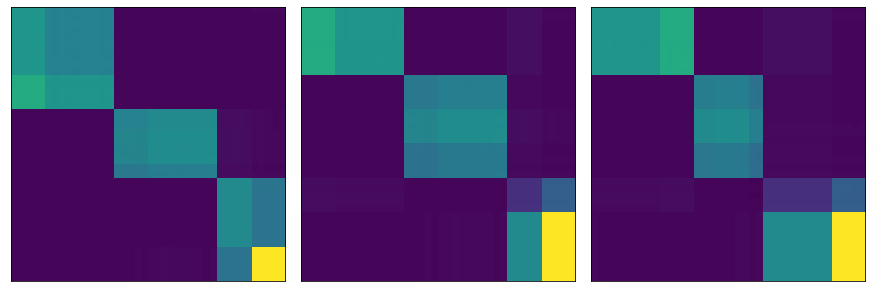

In [15]:
model = NMF(n_components=5, init='random', random_state=0)
A_1_0 = model.fit_transform(X_1)
S_1_1 = model.components_

model = NMF(n_components=5, init='random', random_state=0)
A_2_0 = model.fit_transform(X_2)
S_2_1 = model.components_

model = NMF(n_components=5, init='random', random_state=0)
A_3_0 = model.fit_transform(X_3)
S_3_1 = model.components_

X_approx_5 = outer_product_np(A_1_0 @ S_1_1, A_2_0 @ S_2_1, A_3_0 @ S_3_1)

print(np.linalg.norm(np.ndarray.flatten(X_np-X_approx_5), 2))
print(np.linalg.norm(np.ndarray.flatten(X_np-X_approx_5), 2)  / np.linalg.norm(np.ndarray.flatten(X_np), 2))

fig, ax = plt.subplots(1, 3, constrained_layout=True, figsize=(12,5))
ax[0].axes.get_xaxis().set_ticks([])
ax[0].axes.get_yaxis().set_ticks([])
ax[1].axes.get_xaxis().set_ticks([])
ax[1].axes.get_yaxis().set_ticks([])
ax[2].axes.get_xaxis().set_ticks([])
ax[2].axes.get_yaxis().set_ticks([])
X_max = np.max(X_approx_5,axis=0)
ax[0].imshow(X_max, vmin=vmin, vmax=vmax)
X_max = np.max(X_approx_5,axis=1)
ax[1].imshow(X_max, vmin=vmin, vmax=vmax)
X_max = np.max(X_approx_5,axis=2)
ax[2].imshow(X_max, vmin=vmin, vmax=vmax)

plt.show()

### Rank 3 (for HNCPD)

98.12973732024317
0.7387915983226643


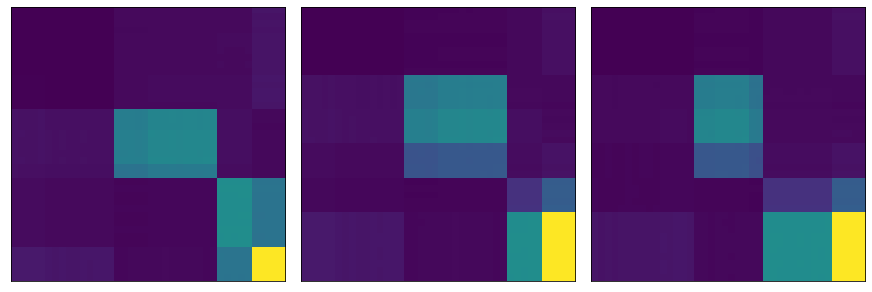

In [16]:
model = NMF(n_components=3, init='random', random_state=0)
A_1_1 = model.fit_transform(S_1_1)
S_1_2 = model.components_

model = NMF(n_components=3, init='random', random_state=0)
A_2_1 = model.fit_transform(S_2_1)
S_2_2 = model.components_

model = NMF(n_components=3, init='random', random_state=0)
A_3_1 = model.fit_transform(S_3_1)
S_3_2 = model.components_

X_approx_3 = outer_product_np(A_1_0 @ A_1_1 @ S_1_2, A_2_0 @ A_2_1 @ S_2_2, A_3_0 @ A_3_1 @ S_3_2)

print(np.linalg.norm(np.ndarray.flatten(X_np-X_approx_3), 2))
print(np.linalg.norm(np.ndarray.flatten(X_np-X_approx_3), 2) / np.linalg.norm(np.ndarray.flatten(X_np), 2))


fig, ax = plt.subplots(1, 3, constrained_layout=True, figsize=(12,5))
ax[0].axes.get_xaxis().set_ticks([])
ax[0].axes.get_yaxis().set_ticks([])
ax[1].axes.get_xaxis().set_ticks([])
ax[1].axes.get_yaxis().set_ticks([])
ax[2].axes.get_xaxis().set_ticks([])
ax[2].axes.get_yaxis().set_ticks([])
X_max = np.max(X_approx_3,axis=0)
ax[0].imshow(X_max, vmin=vmin, vmax=vmax)
X_max = np.max(X_approx_3,axis=1)
ax[1].imshow(X_max, vmin=vmin, vmax=vmax)
X_max = np.max(X_approx_3,axis=2)
ax[2].imshow(X_max, vmin=vmin, vmax=vmax)

plt.show()